# Package installation

In [ ]:
pip install rdkit pandas scikit-learn matplotlib seaborn lightgbm lazypredict tqdm pathlib tqdm lazypredict pathlib lightgbm

# Import libraries and functions

In [1]:
# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder


In [2]:
# Install all modules used in this project

# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import lazypredict
OneHotEncoder(handle_unknown="ignore", sparse_output=False)
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm
#from tqdm import tqdmcore


# Data importing and treatment
## Load .csv file for obtain molecules SMILES 

In [3]:
# Load the CSV file
file_path = 'CCS_smiles.csv'
df = pd.read_csv(file_path, quotechar='"',delimiter=',')
#read columns 
print(df.columns)


Index(['CCS', 'Molecular_Weight', 'LogP', 'H_Donors', 'H_Acceptors',
       'Rotatable_Bonds', 'SMILES'],
      dtype='object')


## Remove rows with Nan values

In [4]:
df = df.dropna()  # Optionally, drop rows with missing values

Now we want to check the data that we have as dataset for training and test sets

## Data set visualisation 

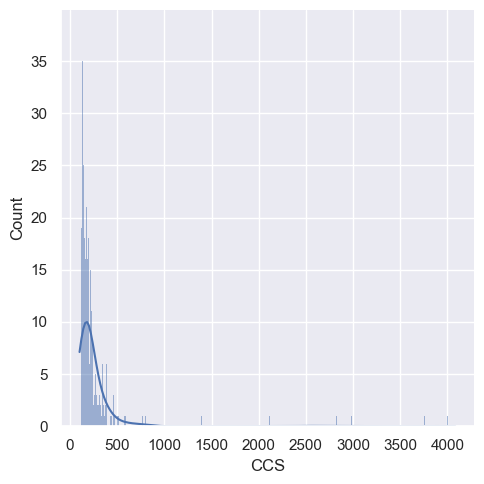

In [5]:
import seaborn as sn

sn.set_theme()
sn.displot(data=df, x="CCS", binwidth=1, kde=True)

## Target small organic molecules, filter to keep data of interest  

In [6]:
new_data_set = df[df.CCS.apply(lambda x: x > 90.0 and x < 250.0)]

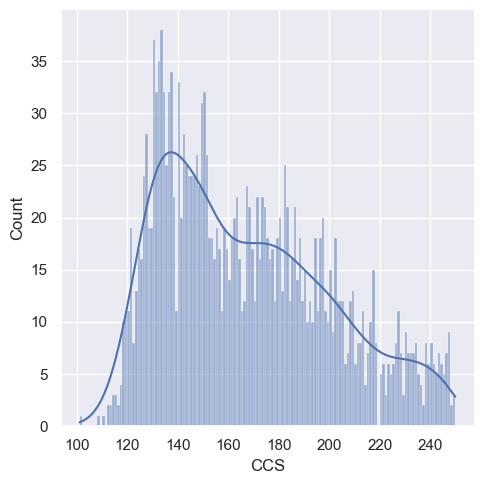

In [7]:
sn.displot(data=new_data_set, x="CCS", binwidth=1, kde=True)

## Save CCS filtered data into a new csv file

In [8]:
new_data_set.to_csv('Data_Cleaned_CCS.csv', index=False)

In [9]:
data_dl = 'Data_Cleaned_CCS.csv'

## Calculate molecular descriptor with RDkit and save it 

In [11]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from tqdm import tqdm
from rdkit import Chem

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 210 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(new_data_set['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:27<00:00, 72.62it/s]


In [12]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
1,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
2,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
3,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
4,14.10,14.10,0.33,-7.12,0.06,55.50,745.43,715.19,745.09,266,...,0,0,0,0,0,0,0,0,0,0


## Molecular descriptors for the data sets

In [19]:
#load test data
data_dl = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')
Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:27<00:00, 71.87it/s]


save in .csv file

In [21]:
df_descriptors.to_csv('Data_descriptor.csv', index=False)
data_dl_descriptors.to_csv('Data_Test_descriptor.csv', index=False)

Load data 

In [47]:
df_descriptors = pd.read_csv('Data_descriptor.csv', delimiter=',')
data_cleaned_final = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')

In [48]:
# Step 1: Combine X and y temporarily to identify bad rows
data_combined = pd.concat([df_descriptors, data_cleaned_final.CCS], axis=1)

# Step 2: Remove rows with NaN or infinite values
cleaned_data_combined = data_combined.replace([np.inf, -np.inf], np.nan).dropna()

# Step 3: Split back into X and y
df_descriptors_clean = cleaned_data_combined.drop(columns='CCS')
data_cleaned_final_clean = cleaned_data_combined['CCS']

# Display the cleaned datasets
print("Cleaned Features (X):")
print(df_descriptors_clean)

print("\nCleaned Target (y):")
print(data_cleaned_final_clean)

Cleaned Features (X):
      MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0                 13.92           13.92               0.12           -6.94   
1                 13.92           13.92               0.12           -6.94   
2                 13.92           13.92               0.12           -6.94   
3                 13.92           13.92               0.12           -6.94   
4                 14.10           14.10               0.33           -7.12   
...                 ...             ...                ...             ...   
1987               7.83            7.83               0.01           -3.53   
1988               8.23            8.23               0.15           -4.04   
1989               8.40            8.40               0.47           -3.66   
1990              10.69           10.69               0.10           -2.97   
1991              10.69           10.69               0.10           -2.97   

      qed   SPS  MolWt  HeavyAtomMolWt  E

In [56]:
df_descriptors_clean.to_csv('Data_descriptor.csv', index=False)
data_cleaned_final_clean.to_csv('Data_Cleaned_CCS.csv', index=False)

In [57]:
df_descriptors = pd.read_csv('Data_descriptor.csv', delimiter=',')
data_cleaned_final = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')

Split the data for training and testing set

In [59]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.CCS, test_size=0.1,random_state=42)

Check loaded data

In [60]:
# Check for NaNs
import numpy as np
print(np.any(np.isnan(x_train)))  # Should return False
print(np.any(np.isnan(y_train)))  # Should return False

# Check for infinite values
print(np.any(np.isinf(x_train)))  # Should return False
print(np.any(np.isinf(y_train)))  # Should return False

# Check data shape
print(x_train.shape, y_train.shape)


False
False
False
False
(1773, 210) (1773,)


# Machine Learning preparation

## Data standardisation (prevent dominance and enhance data consistence)

In [62]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

## LazyRegressor --> Best regressor preview 

In [63]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:23<00:00,  1.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18949
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 164
[LightGBM] [Info] Start training from score 167.392656


In [64]:
prediction_tests[:1000]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,26658519690027046729703264783937025377989533492...,-1759191654671835518703682613492808705123650853...,1383221763982321530116767744.00,0.06
RANSACRegressor,1223003290314360511004672.00,-80705800883688771158016.00,9368878597112.17,0.45
SGDRegressor,81850217944.45,-5401283416.59,2423727.10,0.02
KernelRidge,389.91,-24.66,167.07,0.09
GaussianProcessRegressor,74.14,-3.83,72.45,0.65
QuantileRegressor,16.83,-0.04,33.71,0.31
DummyRegressor,16.17,-0.00,33.00,0.02
MLPRegressor,4.46,0.77,15.75,2.54
PassiveAggressiveRegressor,3.29,0.85,12.81,0.03


# LGBMRegressor 

## Tests with differents features treatment :

## 1.raw data set

## HyperParameters tuning

In [99]:
#params = {'max_depth' : list(range(10, 20, 2)),
#          'n_estimators' : list(range(1100, 1300, 100)) ,
#          'learning_rate': list(np.arange(0.02, 0.04, 0.01))}

#grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=5, verbose=1)

#grid_search.fit(x_train, y_train)

#print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 750}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.009000000000000001, 'max_depth': 3, 'n_estimators': 700}

Model training and testing set

## Model settings

In [65]:
model = LGBMRegressor(n_estimators = 700,
                      max_depth = 3,
                      learning_rate = 0.009,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18949
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 164
[LightGBM] [Info] Start training from score 167.392656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### define a class for a plot

In [66]:
def plot_data(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted, y=actual, line_kws={"lw": 2, "ls": "--", "color": "red", "alpha": 0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted CCS", color="blue")
    plt.xlim(120, 250)
    plt.ylabel("Experimental CCS", color="blue")
    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

### plot experimental CCS vs predicted CCS

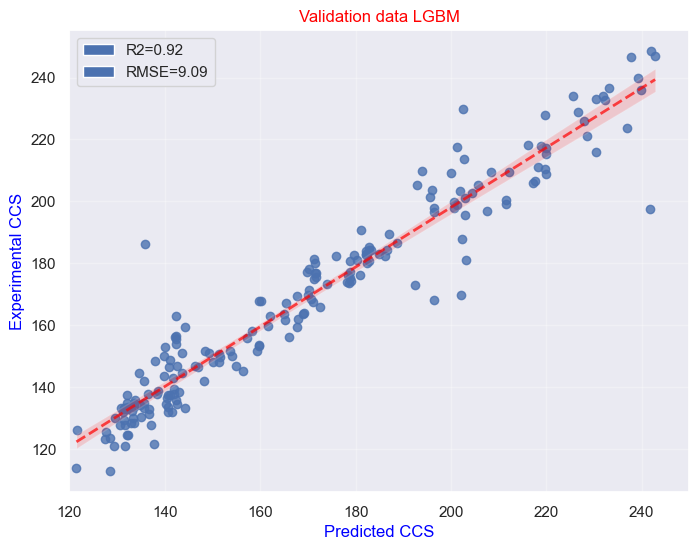

In [67]:
plot_data(y_valid, y_preds, "Validation data LGBM")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds})
data_to_save.to_csv('data_LGBM.csv', index=False)

# (

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming you already have y_valid (true values) and y_preds (predictions)

# Calculate residuals
residuals = y_valid - y_preds

# Define a threshold for high residuals (e.g., top 10%)
threshold = np.percentile(np.abs(residuals), 90)
high_residuals = np.abs(residuals) > threshold

# Assuming 'data' is your full validation DataFrame with features and predictions
# You should have the features in 'data' and the columns should include 'true_values' and 'predicted_values'
data['residuals'] = residuals
data['high_residual'] = high_residuals

# Extract feature columns (excluding 'true_values' and 'predicted_values')
feature_columns = [col for col in data.columns if col not in ['true_values', 'predicted_values', 'residuals', 'high_residual']]

# Compare features
for feature in feature_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='high_residual', y=feature, data=data)
    plt.title(f'Feature: {feature} vs. High Residuals')
    plt.show()

# Correlation with residuals (calculating correlation for each feature)
correlations = data[feature_columns].corrwith(data['residuals'])
print(correlations.sort_values(ascending=False))


In [ ]:
# Calculate correlation of each feature with the residuals
correlations = data[feature_columns].corrwith(data['residuals'])

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Display the sorted correlations
print(sorted_correlations)


In [ ]:
# Calculate correlation of each feature with the residuals
correlations = data[feature_columns].corrwith(data['residuals'])

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Save the sorted correlations to a CSV file
sorted_correlations.to_csv('feature_residual_correlations.csv', header=True)

print("Correlations saved to 'feature_residual_correlations.csv'")


In [ ]:
y_train.shape

In [ ]:
import numpy as np

# Check for infinity values in x_train
print(np.any(np.isinf(x_train)))  # Should return False if no infinity values
print(np.any(np.isnan(x_train)))  # Should return False if no NaN values

# Check for values that are too large
print(np.max(np.abs(x_train)))  # Check the max value in the dataset


In [ ]:
# Replace infinity values with NaN
x_train = np.where(np.isinf(x_train), np.nan, x_train)
# Convert back to DataFrame for easier handling if it's not already
import pandas as pd
x_train_df = pd.DataFrame(x_train)

# Drop rows with NaN or infinite values
x_train_cleaned = x_train_df.dropna()

# If you want to fill NaNs with the mean of each column:
# x_train_cleaned = x_train_df.fillna(x_train_df.mean())

# After replacing inf with NaN, you can handle NaN values as before (e.g., drop or fill with a default value).

In [ ]:
# Ensure no inf or NaN values are present
print(np.any(np.isinf(x_train_cleaned)))  # Should return False
print(np.any(np.isnan(x_train_cleaned)))  # Should return False


In [ ]:
x_train_cleaned

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],             # Maximum depth of individual regression estimators
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                             # Cross-validation folds
    verbose=1,
    n_jobs=-1                         # Use all available cores
)

# Perform the search
grid_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions or evaluate further


In [ ]:
y_train.shape

In [ ]:
x_train.shape

# )

# 2.Features selections based on variance

## Remove low variance features 

In [68]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)  # Set a variance threshold (columns with variance <0.1 is removed)
filtered_data = selector.fit_transform(df_descriptors)

# Get the column names that were retained
selected_columns = df_descriptors.columns[selector.get_support()]

# Create a new DataFrame with the retained columns
df_descriptors_variance_filtered = pd.DataFrame(filtered_data, columns=selected_columns)

# Save to a new .csv file
df_descriptors_variance_filtered.to_csv("df_descriptors_Variance_filtered.csv", index=False)


## Separate data in training and test set under different names 

In [69]:
x_train_variance_filtered, x_valid_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered = train_test_split(df_descriptors_variance_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

In [71]:
scaler = StandardScaler()
scaler.fit(x_train_variance_filtered)
x_train_scaled_variance_filtered = scaler.transform(x_train_variance_filtered)
x_valid_scaled_variance_filtered = scaler.transform(x_valid_variance_filtered)

In [72]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_variance_filtered, x_valid_scaled_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:17<00:00,  2.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16346
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 138
[LightGBM] [Info] Start training from score 167.392656


In [73]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.74,0.93,8.97,1.96
RandomForestRegressor,0.73,0.92,9.11,4.99
BaggingRegressor,0.73,0.92,9.12,0.53
HistGradientBoostingRegressor,0.73,0.92,9.17,0.39
KNeighborsRegressor,0.73,0.92,9.19,0.02


In [75]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the model
baseline_model = GradientBoostingRegressor(random_state=42)
baseline_model.fit(x_train_scaled_variance_filtered, y_train_variance_filtered)

# Evaluate on the validation set
y_pred_baseline = baseline_model.predict(x_valid_scaled_variance_filtered)
baseline_mse = mean_squared_error(y_valid_variance_filtered, y_pred_baseline)
print(f"Baseline MSE: {baseline_mse}")


Baseline MSE: 80.40897005119129


In [78]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Initialize the model
gbm = GradientBoostingRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(x_train_scaled_variance_filtered, y_train_variance_filtered)

# Best parameters and performance
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 1.0}


learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0

In [83]:
# Train the best model
best_model.fit(x_train_scaled_variance_filtered, y_train_variance_filtered)

# Predictions
y_pred_final = best_model.predict(x_valid_scaled_variance_filtered)

# Evaluate using MSE or other metrics
final_mse = mean_squared_error(y_valid_variance_filtered, y_pred_final)
print(f"Final MSE: {final_mse}")


Final MSE: 75.49560076621034


### Cross Validation

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Perform 5-fold cross-validation with neg_mean_squared_error
cv_scores = cross_val_score(
    best_model, 
    x_train_scaled_variance_filtered, 
    y_train_variance_filtered, 
    scoring='neg_mean_squared_error', 
    cv=5
)

# Calculate the mean cross-validated MSE
mean_cv_mse = -cv_scores.mean()
print(f"Cross-Validated MSE: {mean_cv_mse}")


Cross-Validated MSE: 73.20247842126128


### Features importance

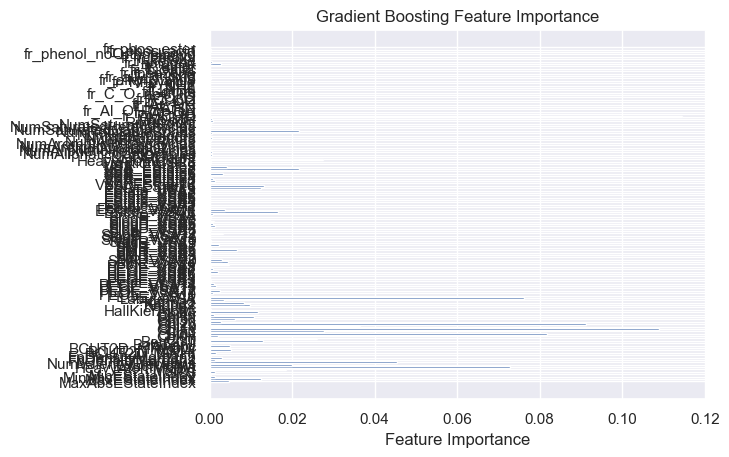

In [85]:
import matplotlib.pyplot as plt
feature_importances = best_model.feature_importances_
plt.barh(selected_columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()


In [86]:
# Train the model on the full training set
best_model.fit(x_train_scaled_variance_filtered, y_train_variance_filtered)

# Predict for the validation set
y_pred_valid = best_model.predict(x_valid_scaled_variance_filtered)

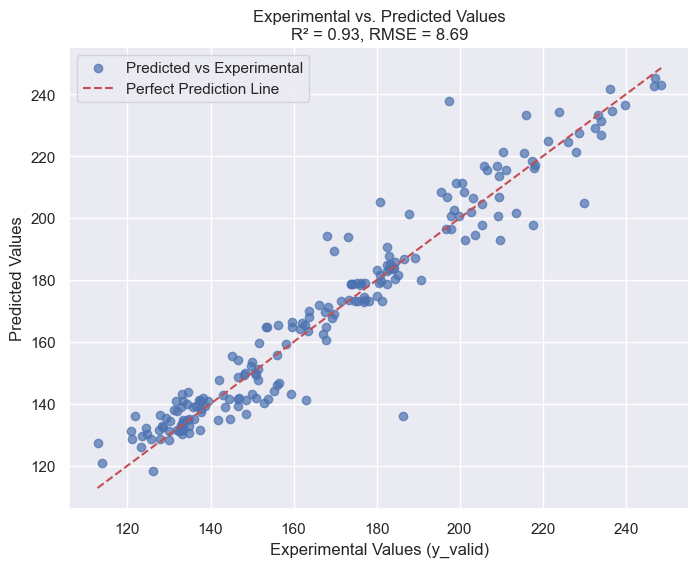

In [87]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions on the validation set
y_pred_valid = best_model.predict(x_valid_scaled_variance_filtered)

# Calculate R-squared (R²)
r2 = r2_score(y_valid_variance_filtered, y_pred_valid)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_valid_variance_filtered, y_pred_valid))

# Plot Experimental vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_valid_variance_filtered, y_pred_valid, alpha=0.7, color='b', label="Predicted vs Experimental")
plt.plot([y_valid_variance_filtered.min(), y_valid_variance_filtered.max()],
         [y_valid_variance_filtered.min(), y_valid_variance_filtered.max()],
         color='r', linestyle='--', label="Perfect Prediction Line")
plt.xlabel("Experimental Values (y_valid)")
plt.ylabel("Predicted Values")
plt.title(f"Experimental vs. Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}")
plt.legend()
plt.show()


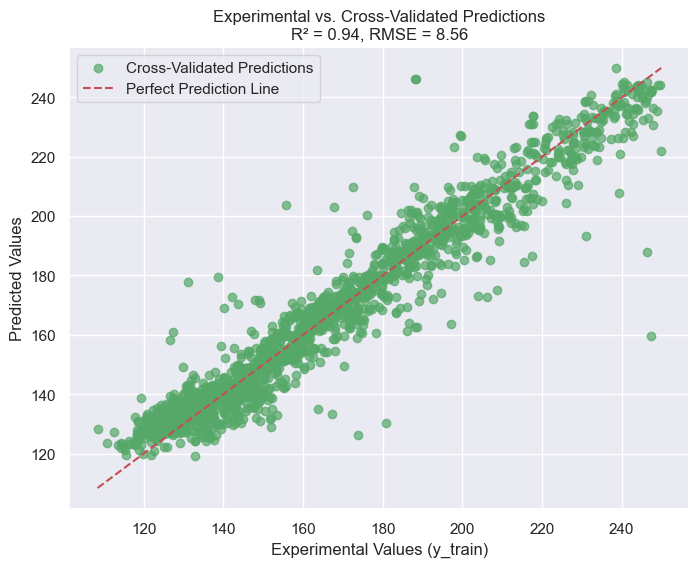

In [88]:
from sklearn.model_selection import cross_val_predict

# Generate cross-validated predictions
y_pred_cv = cross_val_predict(best_model, x_train_scaled_variance_filtered, y_train_variance_filtered, cv=5)

# Calculate R-squared (R²)
r2_cv = r2_score(y_train_variance_filtered, y_pred_cv)

# Calculate RMSE (Root Mean Squared Error)
rmse_cv = np.sqrt(mean_squared_error(y_train_variance_filtered, y_pred_cv))

# Plot Experimental vs. Cross-Validated Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_train_variance_filtered, y_pred_cv, alpha=0.7, color='g', label="Cross-Validated Predictions")
plt.plot([y_train_variance_filtered.min(), y_train_variance_filtered.max()],
         [y_train_variance_filtered.min(), y_train_variance_filtered.max()],
         color='r', linestyle='--', label="Perfect Prediction Line")
plt.xlabel("Experimental Values (y_train)")
plt.ylabel("Predicted Values")
plt.title(f"Experimental vs. Cross-Validated Predictions\nR² = {r2_cv:.2f}, RMSE = {rmse_cv:.2f}")
plt.legend()
plt.show()


### HyperParameters optimization with cross Validation

In [89]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

In [90]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gbr, 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # We want to minimize MSE
                           n_jobs=-1,  # Use all cores for faster computation
                           verbose=1)  # Print progress during grid search


In [91]:
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}# Fit the grid search
grid_search.fit(x_train_scaled_variance_filtered, y_train_variance_filtered)

# Get the best parameters found during the search
best_params = grid_search.best_params_
print(f"Best HypeBest Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}rparameters: {best_params}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}


In [94]:
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}

In [95]:
best_params

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_split': 10,
 'n_estimators': 300,
 'subsample': 1.0}

In [96]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_valid = best_model.predict(x_valid_scaled_variance_filtered)

# Calculate R² and RMSE for validation predictions
from sklearn.metrics import r2_score, mean_squared_error
r2_valid = r2_score(y_valid_variance_filtered, y_pred_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid_variance_filtered, y_pred_valid))

print(f"R² on validation set: {r2_valid:.2f}")
print(f"RMSE on validation set: {rmse_valid:.2f}")


R² on validation set: 0.93
RMSE on validation set: 8.96


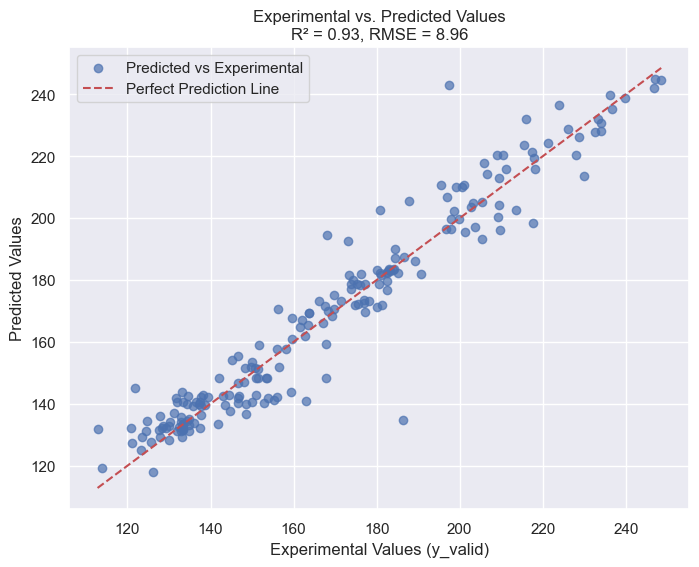

In [97]:
import matplotlib.pyplot as plt

# Plot Experimental vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_valid_variance_filtered, y_pred_valid, alpha=0.7, color='b', label="Predicted vs Experimental")
plt.plot([y_valid_variance_filtered.min(), y_valid_variance_filtered.max()],
         [y_valid_variance_filtered.min(), y_valid_variance_filtered.max()],
         color='r', linestyle='--', label="Perfect Prediction Line")
plt.xlabel("Experimental Values (y_valid)")
plt.ylabel("Predicted Values")
plt.title(f"Experimental vs. Predicted Values\nR² = {r2_valid:.2f}, RMSE = {rmse_valid:.2f}")
plt.legend()
plt.show()


# 3. Filter Features Based on Correlation

In [98]:
# Compute the correlation matrix
correlation_matrix = df_descriptors.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of features with high correlation (e.g., >0.9)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
df_descriptors_correlation_filtered = df_descriptors.drop(columns=to_drop)
print(f"Removed features: {to_drop}")

Removed features: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa3', 'LabuteASA', 'SMR_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA2', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'VSA_EState7', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_Imine', 'fr_Nhpyrrole', 'fr_alkyl_halide', 'fr_benzene', 'fr_halogen', 'fr_nitro_arom', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


In [99]:
x_train_correlation_filtered, x_valid_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered = train_test_split(df_descriptors_correlation_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_correlation_filtered)
x_train_scaled_correlation_filtered = scaler.transform(x_train_correlation_filtered)
x_valid_scaled_correlation_filtered = scaler.transform(x_valid_correlation_filtered)

In [100]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_correlation_filtered, x_valid_scaled_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:22<00:00,  1.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11344
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 113
[LightGBM] [Info] Start training from score 167.392656


In [101]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.63,0.93,8.88,2.13
RandomForestRegressor,0.61,0.92,9.18,5.77
LGBMRegressor,0.60,0.92,9.25,0.19
HistGradientBoostingRegressor,0.60,0.92,9.26,0.55
BaggingRegressor,0.59,0.92,9.34,0.53


# 4. Dimensional Reduction --> PCA

In [131]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Step 1: Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_descriptors)

# Step 2: Perform PCA to reduce the number of components
pca = PCA(n_components=10)  # Adjust the number of components as needed
reduced_data = pca.fit_transform(df_imputed)

# Step 3: Convert the reduced data to a DataFrame
df_descriptors_pca = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# Step 4: Save the PCA DataFrame to a CSV file
df_descriptors_pca.to_csv("pca_reduced_data.csv", index=False)

print("PCA dataset saved to 'pca_reduced_data.csv'")

PCA dataset saved to 'pca_reduced_data.csv'


In [132]:
df_descriptors_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-11971645044118791218555739025093452516818944.00,1732.02,167.95,168.71,-3.57,-8.28,-19.50,5.46,8.94,-23.54
1,-11971645044118677328072124770108161797390336.00,1732.02,167.95,168.71,-3.57,-8.28,-19.50,5.46,8.94,-23.54
2,-11971645044118677328072124770108161797390336.00,1732.02,167.95,168.71,-3.57,-8.28,-19.50,5.46,8.94,-23.54
3,-11971645044118677328072124770108161797390336.00,1732.02,167.95,168.71,-3.57,-8.28,-19.50,5.46,8.94,-23.54
4,-11971645044118461926505289113940329349775360.00,1978.99,246.95,174.43,16.88,-1.43,-20.83,-3.67,-8.54,-22.71
...,...,...,...,...,...,...,...,...,...,...
1966,-11971645044117533471475825078734155006607360.00,-338.57,-65.35,3.04,-29.61,4.02,17.47,3.51,-11.42,12.36
1967,-11971645044117355208110167983974569532719104.00,-234.77,-53.50,-30.65,-12.60,5.31,14.46,-0.99,-11.83,22.99
1968,-11971645044117483953874253663523159041638400.00,-457.03,-140.39,-34.05,-26.59,-2.95,16.21,18.05,13.79,-3.85
1969,-11971645044117342828709775130171820541476864.00,-730.71,-88.07,10.83,-32.24,-17.65,-11.14,6.98,-1.02,2.90


In [133]:
x_train_pca, x_valid_pca, y_train_pca, y_valid_pca = train_test_split(df_descriptors_pca, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_pca)
x_train_scaled_pca = scaler.transform(x_train_pca)
x_valid_scaled_pca = scaler.transform(x_valid_pca)

In [134]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_pca, x_valid_scaled_pca, y_train_pca, y_valid_pca)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00,  8.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 10
[LightGBM] [Info] Start training from score 167.392656


In [135]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.92,0.93,8.93,0.48
HistGradientBoostingRegressor,0.92,0.92,9.13,0.18
LGBMRegressor,0.92,0.92,9.16,0.06
RandomForestRegressor,0.91,0.92,9.41,1.07
XGBRegressor,0.91,0.91,9.70,0.08


### Random search for hyperparamater (faster)

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter distribution (instead of grid, it's a distribution for random sampling)
param_dist = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],             # Maximum depth of individual regression estimators
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,  # The parameter distribution to sample from
    n_iter=50,                       # Number of parameter settings to sample
    scoring='neg_mean_squared_error', # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                            # Cross-validation folds
    verbose=1,                       
    n_jobs=-1                        # Use all available cores
)

# Perform the search
random_search.fit(x_train_scaled_pca, y_train_pca)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_model_gbr = random_search.best_estimator_

# Use the best model to make predictions or evaluate further

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.1}


### Grid search for hyperParamater

In [155]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [25, 50, 75],      # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.15],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3.5, 5, 4.5],             # Maximum depth of individual regression estimators
    'min_samples_split': [4, 5, 6],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 0.6],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                             # Cross-validation folds
    verbose=1,
    n_jobs=-1                         # Use all available cores
)

# Perform the search
grid_search.fit(x_train_scaled_pca, y_train_pca)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions or evaluate further

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}


# PCA data tests

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 800}

In [137]:
model = LGBMRegressor(n_estimators = 750,
                      max_depth = 6,
                      learning_rate = 0.015,
                      random_state= 42)

model.fit(x_train_scaled_pca,y_train_pca)
y_preds_pca = model.predict(x_valid_scaled_pca)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 10
[LightGBM] [Info] Start training from score 167.392656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

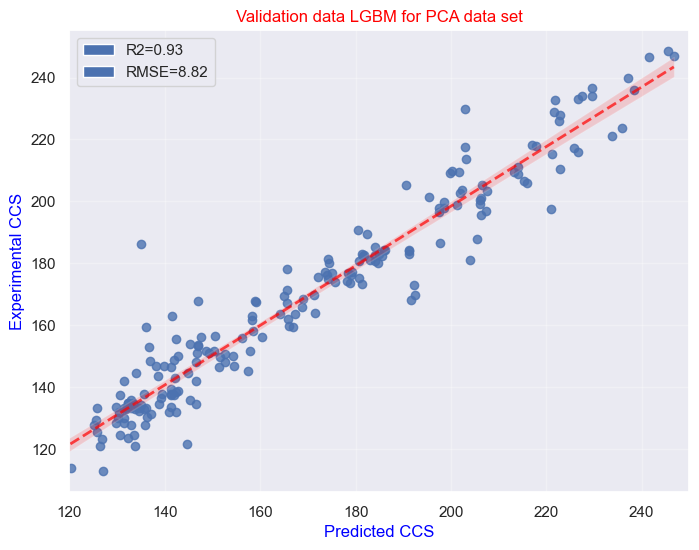

In [138]:
plot_data(y_valid_pca, y_preds_pca, "Validation data LGBM for PCA data set")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid_pca, 'Predicted Values': y_preds_pca})
data_to_save.to_csv('data_LGBM.csv', index=False)

In [153]:
from sklearn.ensemble import GradientBoostingRegressor
from math import log  # Importing log function from math module

# Define the model with the correct parameters
model_GBR = GradientBoostingRegressor(
    learning_rate = 0.1, 
    max_depth = 5, 
    max_features = None,  # Correct use of log function
    min_samples_leaf = 1, 
    min_samples_split = 5, 
    n_estimators = 50, 
    subsample = 0.8
)

# Fit the model with training data
model_GBR.fit(x_train_scaled_pca, y_train_pca)

# Predict on validation set
y_preds_GBR_pca = model_GBR.predict(x_valid_scaled_pca)


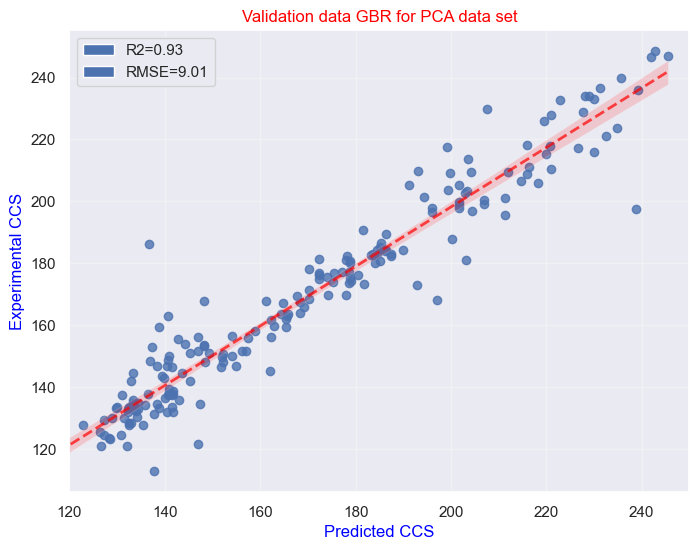

In [154]:
plot_data(y_valid_pca, y_preds_GBR_pca, "Validation data GBR for PCA data set")

In [141]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
import numpy as np

# Define the LGBM model (LightGBM)
model1 = LGBMRegressor(n_estimators=750,
                       max_depth=6,
                       num_leaves=64,  # Corrected based on max_depth
                       learning_rate=0.015,
                       random_state=42)

# Define the XGBoost model (XGBRegressor)
model2 = XGBRegressor(learning_rate=0.1, 
                      max_depth=5, 
                      min_samples_leaf=1, 
                      min_samples_split=5, 
                      n_estimators=100, 
                      subsample=1.0,
                      colsample_bytree=0.8,  # Instead of max_features
                      random_state=42)

# Define the Voting Regressor combining both models
voting_model = VotingRegressor(estimators=[
    ('lgbm', model1), 
    ('xgb', model2)
])

# Fit the model on training data
voting_model.fit(x_train_scaled_pca, y_train_pca)

# Make predictions on validation data
predictions = voting_model.predict(x_valid_scaled_pca)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 10
[LightGBM] [Info] Start training from score 167.392656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

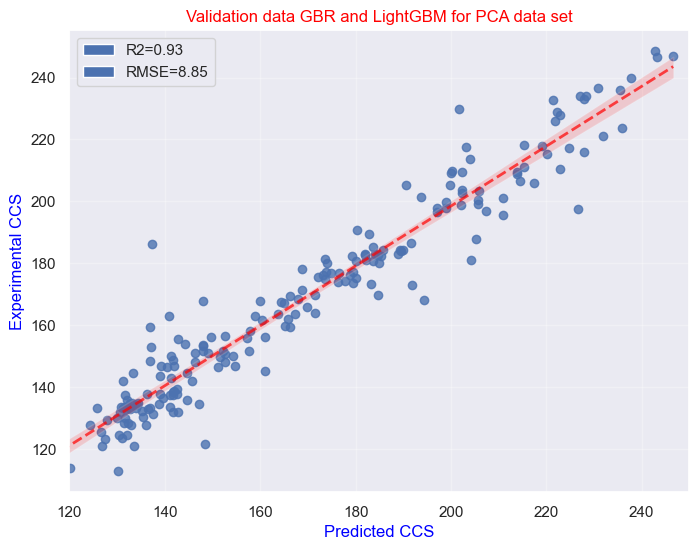

In [142]:
plot_data(y_valid_pca, predictions,  "Validation data GBR and LightGBM for PCA data set")

#### Combined data are not very interressant due to a bigger RMSE

# test on reduced data set (90<CCS<170)

In [ ]:
reduced_data_set = df[df.CCS.apply(lambda x: x > 120.0 and x < 170.0)]

In [ ]:
sn.displot(data=reduced_data_set, x="CCS", binwidth=1, kde=True)

In [ ]:
reduced_data_set.to_csv('reduced_data_CCS.csv', index=False)

In [ ]:
reduced_data = pd.read_csv("reduced_data_CCS.csv", delimiter=',')
Mol_descriptors_test , desc_names_test = RDkit_descriptors(reduced_data["SMILES"])
reduced_data_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

In [ ]:
x_train_reduced, x_valid_reduced, y_train_reduced, y_valid_reduced = train_test_split(reduced_data_descriptors, reduced_data_set.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_reduced)
x_train_scaled_reduced = scaler.transform(x_train_reduced)
x_valid_scaled_reduced = scaler.transform(x_valid_reduced)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
model, prediction_tests = lregs.fit(x_train_scaled_reduced, x_valid_scaled_reduced, y_train_reduced, y_valid_reduced)

In [ ]:
prediction_tests[:1000]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # Or the model of your choice
from sklearn.metrics import mean_squared_error
import numpy as np

def randomized_search_optimization(data_descriptors, target, param_distributions, n_iter=100):
    # Step 1: Split the data
    x_train_reduced, x_valid_reduced, y_train_reduced, y_valid_reduced = train_test_split(
        data_descriptors, target, test_size=0.1, random_state=42
    )

    # Step 2: Scale the data
    scaler = StandardScaler()
    scaler.fit(x_train_reduced)
    x_train_scaled_reduced = scaler.transform(x_train_reduced)
    x_valid_scaled_reduced = scaler.transform(x_valid_reduced)

    # Step 3: Initialize the model
    model = RandomForestRegressor(random_state=42)

    # Step 4: Perform Randomized Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of parameter settings to try
        scoring='neg_mean_squared_error',  # Replace with appropriate metric for your task
        cv=5,  # Cross-validation folds
        verbose=2,
        random_state=42,
        n_jobs=-1  # Use all cores
    )

    random_search.fit(x_train_scaled_reduced, y_train_reduced)

    # Step 5: Evaluate the best model on the validation set
    best_model = random_search.best_estimator_
    y_valid_pred = best_model.predict(x_valid_scaled_reduced)
    validation_score = mean_squared_error(y_valid_reduced, y_valid_pred)

    
    return random_search.best_params_, validation_score



In [ ]:
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)


In [ ]:
param_distributions = {
    'n_estimators': [300, 400, 500, 600, 700],
    'max_depth': [4, 6, 8, 10, 12, 14],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [5, 3, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)


In [ ]:
param_distributions = {
    'n_estimators': [540, 570, 600, 630, 660],
    'max_depth': [5, 6, 7, 8, 4],
    'min_samples_split': [2, 4, 3],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)

In [ ]:
model = LGBMRegressor(n_estimators = 600,
                      max_depth = 5,
                      learning_rate = 0.01,
                      random_state= 42,
                      min_samples_split= 4,
                      min_samples_leaf= 4,
                      bootstrap= True)

model.fit(x_train_scaled_reduced,y_train_reduced)
y_preds_reduced = model.predict(x_valid_scaled_reduced)

In [ ]:
plot_data(y_valid_reduced, y_preds_reduced, "Validation data LGBM for reduced data set")

# Reduced data set in function of residuals correlation

In [ ]:
# Filter the correlations to keep only those between -0.07 and 0.07
filtered_features = sorted_correlations[(sorted_correlations > -0.07) & (sorted_correlations < 0.07)]

# Display the features that are kept
print("Filtered features with correlation between -0.07 and 0.07:", filtered_features.index.tolist())

# Select only the filtered features from your data for predictions
filtered_data = df_descriptors[filtered_features.index.tolist()]

# Now you can use 'filtered_data' for your predictions or model training


In [ ]:
filtered_data

In [ ]:
x_train_cor, x_valid_cor, y_train_cor, y_valid_cor = train_test_split(filtered_data, data_cleaned_final.CCS, test_size=0.1,random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train_cor)
x_train_scaled_cor = scaler.transform(x_train_cor)
x_valid_scaled_cor = scaler.transform(x_valid_cor)

In [ ]:
model = LGBMRegressor(n_estimators = 700,
                      max_depth = 3,
                      learning_rate = 0.009,
                      random_state= 42)

model.fit(x_train_scaled_cor,y_train_cor)
y_preds_cor = model.predict(x_valid_scaled_cor)

In [ ]:
plot_data(y_valid_cor, y_preds_cor, "Validation data LGBM")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid_cor, 'Predicted Values': y_preds_cor})

# Deeplearning approach 

In [170]:
pip install tensorflow keras torch torchvision pytorch-ignite

   ---------------------------------------- 0.0/312.7 kB ? eta -:--:--
   --------------- ------------------------ 122.9/312.7 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 312.7/312.7 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [184]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(
    df_descriptors, data_cleaned_final.CCS, test_size=0.1, random_state=42
)

# Convert to DataFrame if not already
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train)

# Initialize the imputer (replace NaNs with the mean of each column)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and validation data
x_train_imputed = imputer.fit_transform(x_train_df)
x_valid_imputed = imputer.transform(x_valid)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
x_train_scaled = scaler.fit_transform(x_train_imputed)

# Transform the validation data
x_valid_scaled = scaler.transform(x_valid_imputed)

# Set the variance threshold (e.g., 0.01) to remove features with low variance
selector = VarianceThreshold(threshold=0.01)

# Fit and transform the training data to remove low-variance features
x_train_selected = selector.fit_transform(x_train_scaled)

# Apply the same transformation to the validation data
x_valid_selected = selector.transform(x_valid_scaled)

# Print the number of features before and after selection
print(f"Original feature count: {x_train_scaled.shape[1]}")
print(f"Selected feature count: {x_train_selected.shape[1]}")


Original feature count: 210
Selected feature count: 179


In [185]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality while preserving 95% of variance
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_selected)  # Apply PCA to the selected features
x_valid_pca = pca.transform(x_valid_selected)  # Apply PCA to the validation set

# Print the number of principal components
print(f"Number of principal components: {x_train_pca.shape[1]}")


Number of principal components: 50


In [186]:
from sklearn.preprocessing import StandardScaler

# Scale the data again if PCA or feature selection has changed the feature set
scaler = StandardScaler()

# Apply scaling to the new data after PCA or feature selection
x_train_scaled = scaler.fit_transform(x_train_pca)  # Or use x_train_selected if not using PCA
x_valid_scaled = scaler.transform(x_valid_pca)  # Or use x_valid_selected if not using PCA



In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Input dimension is the number of RDKit descriptors
input_dim = x_train_scaled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
    Dropout(0.3),  # Regularization
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [188]:
from ignite.engine import Events, Engine
from ignite.handlers import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
import ignite

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_valid_scaled, y_valid),
    epochs=100,  # Adjust based on convergence
    batch_size=32,  # Adjust for your dataset size
    callbacks=[early_stopping]
)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 27987.2383 - mae: 163.8537 - val_loss: 22970.6387 - val_mae: 148.4191
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19500.4219 - mae: 135.7440 - val_loss: 8563.7031 - val_mae: 87.3692
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5596.6558 - mae: 67.4495 - val_loss: 1254.3757 - val_mae: 27.8875
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1011.7294 - mae: 25.3307 - val_loss: 741.0242 - val_mae: 18.8394
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 596.1374 - mae: 19.3480 - val_loss: 635.7054 - val_mae: 16.8626
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 548.1989 - mae: 18.2737 - val_loss: 545.2797 - val_mae: 15.6360
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 496.2725 - mae: 17.4657 - val_loss: 515.1381 - val_mae: 14.8068
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 490.0489 - mae: 17.3846 - val_loss: 473.1212 - val_mae: 14.4403
Epo

In [189]:
# Evaluate on the validation set
val_loss, val_mae = model.evaluate(x_valid_scaled, y_valid, verbose=0)

print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

Validation Loss: 161.29798889160156, Validation MAE: 7.790393352508545


In [190]:
import joblib

# Save the model
model.save('ccs_predictor_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

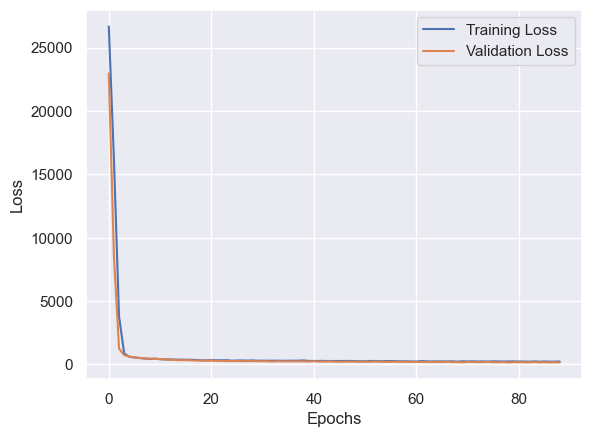

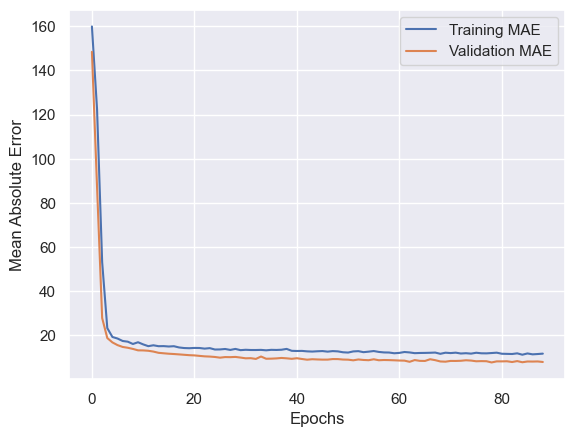

In [191]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [192]:
from sklearn.metrics import mean_absolute_error, r2_score

# Verify shapes of validation data
print(f"x_valid_scaled shape: {x_valid_scaled.shape}")
print(f"y_valid shape: {y_valid.shape}")

# Predict on validation set
y_valid_pred = model.predict(x_valid_scaled)

# Verify shape of predictions
print(f"y_valid_pred shape: {y_valid_pred.shape}")

# Flatten predictions to match target shape
y_valid_pred = y_valid_pred.flatten()

# Evaluate predictions
mae = mean_absolute_error(y_valid, y_valid_pred)
r2 = r2_score(y_valid, y_valid_pred)

print(f"Validation MAE: {mae}")
print(f"Validation R² Score: {r2}")


x_valid_scaled shape: (198, 50)
y_valid shape: (198,)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
y_valid_pred shape: (198, 1)
Validation MAE: 7.790393380829783
Validation R² Score: 0.851694078872856


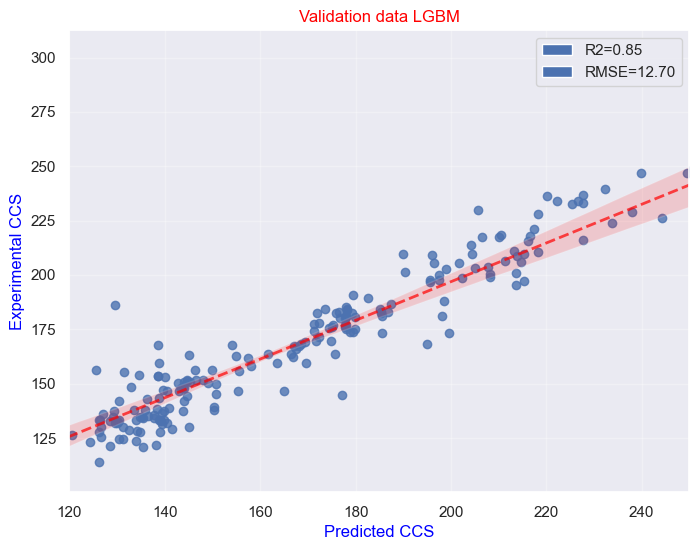

In [193]:
plot_data(y_valid, y_valid_pred, "Validation data LGBM")